In [1]:
def filter_kymo_left(
    kymo, nr_tiles=1, static_offset=1, static_angle=1000, plots=False, perc_dim=6
):
    """
    This is a complicated function, with a lot of considerations. The idea is to make a fourier transform of a
    kymograph, then remove certain parts of it to end up with a spectrum where only forward or backward moving
    particles are shown. Preferably, the DC term of the fourier transform is also removed. Intensity is recovered by
    comparing the dimmest particles of the resulting filtered kymos and the original image.
    kymo:           The input kymograph
    nr_tiles:       The number of tilings that is done to avoid Fourier ringing. Currently only set to one
    static_offset:  How many horizontal bands in the fourier spectrum are removed from the middle. These correspond to vertical lines in real-space.
    static_angle:   The angle of the two triangles that flare from the middle of the spectrum. This to remove static particles from the kymograph that have negligible movement.
    """
    if plots:
        fig, ax = plt.subplots(4, 2, figsize=(9, 18))
        img_max = np.max(kymo.flatten())

    # Final shifting of the filtered kymo is based on the 3% of dimmest pixels. The mean of these have to match up.
    dim_pixls = kymo < np.percentile(kymo, perc_dim)
    dim_val = np.mean(kymo[dim_pixls].flatten())

    # The kymograph is tiled to prevent ringing. This creates a 3x3 tile

    img = kymo.copy()
    for i in range(nr_tiles):
        A = img[:, :]
        B = np.flip(A, axis=0)
        C = np.flip(A, axis=1)
        D = np.flip(B, axis=1)
        tiles = [[D, B, D], [C, A, C], [D, B, D]]
        tiles = [cv2.hconcat(imgs) for imgs in tiles]
        fourrier = cv2.vconcat(tiles)
        img = fourrier
    tiling_for_fourrier = img
    shape_v, shape_h = tiling_for_fourrier.shape

    # We use orthogonal normalization in the fourier transforms to try and get proper intensities back
    dark_image_grey_fourier = np.fft.fftshift(
        np.fft.fft2(tiling_for_fourrier, norm="ortho")
    )
    coordinates_middle = np.array(dark_image_grey_fourier.shape) // 2

    # Within the fourier transform, we have four quadrants, where we remove two of them. This in addition to the DC term
    LT_quadrant = np.s_[: coordinates_middle[0] + 0, : coordinates_middle[1]]
    LB_quadrant = np.s_[coordinates_middle[0] - 1 :, : coordinates_middle[1]]
    RB_quadrant = np.s_[coordinates_middle[0] + 1 :, coordinates_middle[1] + 1 :]
    RT_quadrant = np.s_[: coordinates_middle[0], coordinates_middle[1] :]

    filtered_fourrier = dark_image_grey_fourier.copy()
    # filtered_fourrier[np.abs(filtered_fourrier)<=np.quantile(np.abs(filtered_fourrier),0.7)]=0
    # filtered_fourrier[:,0:120]=0
    # filtered_fourrier[:,180:]=0
    
    # Calculation of the static part of the fourier spectrum. Looks like a horizontal band with vertically flared ends.
    v_axis = np.arange(0, shape_v) - (shape_v // 2)
    h_axis = np.arange(0, shape_h) - (shape_h // 2)
    v_array = np.array([v_axis for i in range(shape_h)]).transpose()
    h_array = np.array([h_axis for i in range(shape_v)])
    stat_array = 1 * (abs(v_array) <= (static_offset + abs(h_array) / static_angle))
    # print(stat_array)
    filtered_fourrier[LT_quadrant] = 0
    filtered_fourrier[RB_quadrant] = 0
    filtered_fourrier *= (1 - stat_array)
    # filtered_fourrier[coordinates_middle[0], coordinates_middle[1]] = 0

    # stat_array[coordinates_middle[0], coordinates_middle[1]] = 0
    stat_filt = np.fft.ifft2(
        np.fft.ifftshift(dark_image_grey_fourier * stat_array), norm="ortho"
    )
    filtered = np.fft.ifft2(np.fft.ifftshift(filtered_fourrier), norm="ortho")

    shape_v, shape_h = shape_v // 3, shape_h // 3
    middle_slice = np.s_[shape_v : 2 * shape_v, shape_h : 2 * shape_h]
    middle_square = np.s_[
        coordinates_middle[0] - 10 : coordinates_middle[0] + 50,
        coordinates_middle[1] - 50 : coordinates_middle[1] + 10,
    ]
    middle = filtered[middle_slice]

    # print(np.sum(abs(stat_filt[middle_slice]).flatten()))

    # img_out = np.abs(middle) - abs(stat_filt[middle_slice])

    # Here the intensity of the image is restored by setting equal the 3 percentile dimmest particles in the image.
    # This works best when there is a decent chunk of video where no particles are present.
    out = middle

    return (np.abs((out)))
#     img_out = middle.real
#     out_dim_pixls = img_out < np.percentile(img_out, perc_dim)
#     out_dim_value = np.mean(img_out[out_dim_pixls].flatten())
#     DC_value = dim_val - out_dim_value

#     return (img_out + DC_value).real

def filter_kymo_right(kymo):
    return(np.flip(filter_kymo_left(np.flip(kymo, axis=1)), axis=1))

In [2]:
import numpy as np
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import imageio

%matplotlib widget
class MovingSpotsVideo:
    def __init__(self, rect_size, left_speed, right_speed, num_spots,num_spots_imobile,bias = 0.5,gaussian_range = (5,20),amplitude_range = (1,10)):
        self.rect_size = rect_size
        self.x, self.y = np.meshgrid(np.linspace(0, self.rect_size[1], self.rect_size[1]), 
                                     np.linspace(0, self.rect_size[0], self.rect_size[0]))
        self.left_speed = left_speed
        self.right_speed = right_speed
        num_spots_left = int(num_spots*bias)
        num_spots_right = int(num_spots*(1-bias))
        self.gaussian_range = gaussian_range
        self.amplitude_range = amplitude_range
        self.bias = bias
        self.spots_right = self.create_initial_spots(num_spots_left)
        self.spots_left = self.create_initial_spots(num_spots_right)
        self.spots_imobile = self.create_initial_spots(num_spots_imobile)

        self.flux = bias * left_speed+(1-bias)*right_speed

    def create_gaussian_spot(self, center):
        # Modified distance calculation for wrapping
        dx = np.minimum(np.abs(self.x - center[1]), self.rect_size[1] - np.abs(self.x - center[1]))
        dy = np.minimum(np.abs(self.y - center[0]), self.rect_size[0] - np.abs(self.y - center[0]))
        d = np.sqrt(dx**2 + dy**2)

        sigma, amplitude = np.random.randint(*self.gaussian_range), np.random.randint(*self.amplitude_range)
        gaussian = amplitude * np.exp(-(d**2 / (2.0 * sigma**2)))
        return gaussian

    def create_initial_spots(self, num_spots):
        initial_image = np.zeros(self.rect_size)
        for _ in range(num_spots):
            center_x = np.random.randint(0, self.rect_size[0])
            center_y = np.random.randint(0, self.rect_size[1])
            gaussian_spot = self.create_gaussian_spot((center_x, center_y))
            initial_image += gaussian_spot

        # Normalize to avoid saturation

        return initial_image


    def move_window(self, initial_img, speed, t):
        shift = int(speed * t)
        if speed > 0:  # Moving right
            moved_img = np.roll(initial_img, shift, axis=1)
        else:  # Moving left
            moved_img = np.roll(initial_img, shift, axis=1)
        return moved_img

    def generate_video(self, num_timesteps,noise_level = 1):
        frames = []
        frames_right= []
        frames_left= []
        
        for t in range(num_timesteps):
            frame_right = self.move_window(self.spots_right, self.right_speed, t)
            frame_left = self.move_window(self.spots_left, self.left_speed, t)
            frame_immobile = self.move_window(self.spots_imobile, 0, t)
            frame_right_mod = cv2.addWeighted(frame_right, 1, frame_immobile, 0.5, 0)
            frame_left_mod = cv2.addWeighted(frame_left, 1, frame_immobile, 0.5, 0)

            frame = cv2.addWeighted(frame_right_mod, 1, frame_left_mod, 1, 0)
            frame += (np.random.random(size = frame.shape)*2-1)*noise_level
            
            frames.append(frame)
            frames_right.append(frame_right)
            frames_left.append(frame_left)
        return frames,frames_right,frames_left
    def get_kymo(self,num_timesteps,noise_level = 1):
        frames,frames_right,frames_left = self.generate_video(num_timesteps,noise_level = noise_level)
        kymo = np.mean(frames,axis=1)
        filtered_kymo_left = filter_kymo_left(kymo)
        filtered_kymo_right = filter_kymo_right(kymo)
        
        return(kymo,filtered_kymo_left,filtered_kymo_right,np.mean(frames_left,axis=1),np.mean(frames_right,axis=1),)
video_generator = MovingSpotsVideo(rect_size=(112, 112*5), left_speed=43, right_speed=-60,gaussian_range = (5,20), num_spots=1000,num_spots_imobile=500,bias = 0.2)
frames,frames_right,frames_left = video_generator.generate_video(num_timesteps=10,noise_level = 5)

2023-12-21 10:33:33.572216: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-21 10:33:34.168461: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/home6/svstaalduine/.local/lib/python3.9/site-packages/cv2/../../lib64:/sw/arch/Centos8/EB_production/2021/software/ZeroMQ/4.3.4-GCCcore-10.3.0/lib:/sw/arch/Centos8/EB_production/2021/software/util-linux/2.36-GCCcore-10.3.0/lib:/sw/arch/Centos8/EB_production/2021/software/libsodium/1.0.18-GCCcore-10.3.0/lib:/sw/arch/Centos8/EB_production/2021/software/OpenPGM/5.2.122-GCCcore-10.3.0/lib:/sw

In [3]:
frames_normalize = cv2.normalize(np.array(frames), None, 0, 254, cv2.NORM_MINMAX, dtype=cv2.CV_8U).astype(np.uint8)
rescaled_images = [img for img in frames_normalize]


In [5]:
for i,frame in enumerate(rescaled_images):
    imageio.imsave(f"frames/frame{i}.png",frame)

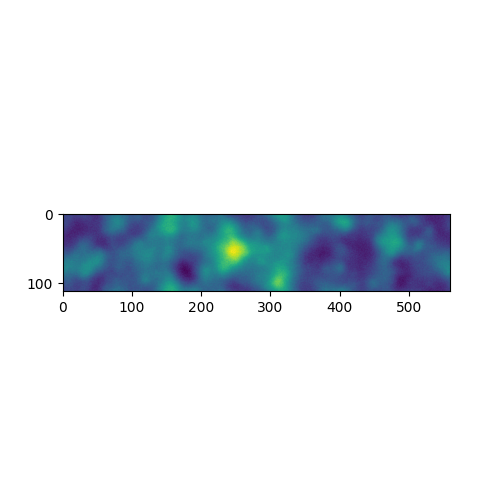

In [6]:
imageio.mimsave('test.mp4',rescaled_images, 'ffmpeg')
fig, ax = plt.subplots(figsize = (5,5))
ax.imshow(frames[2])



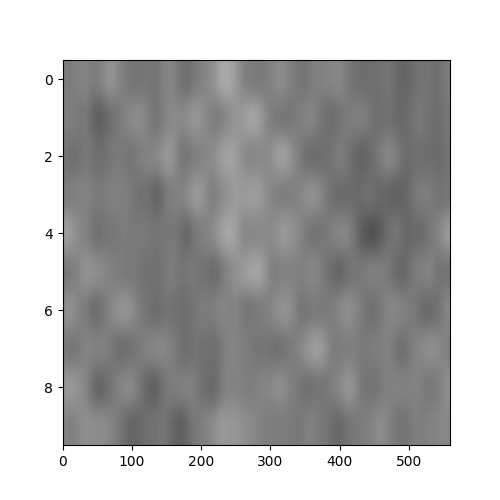

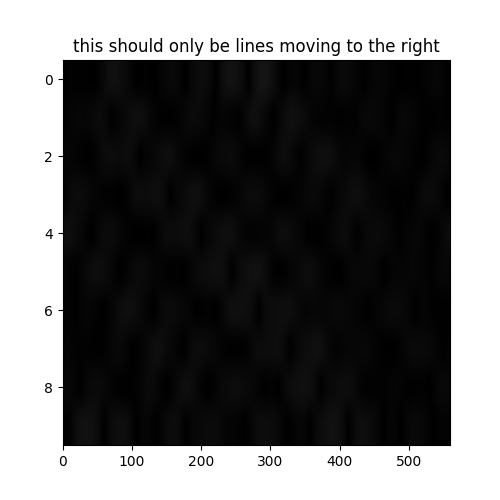

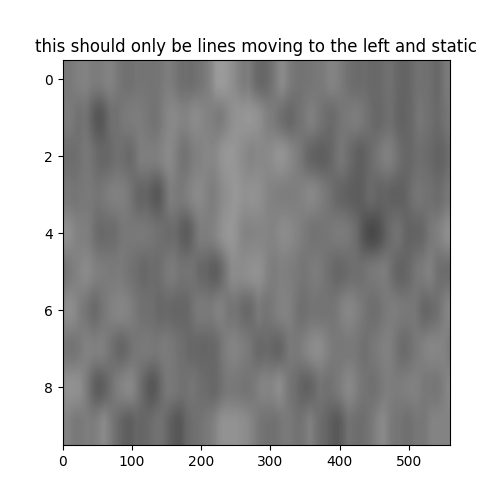

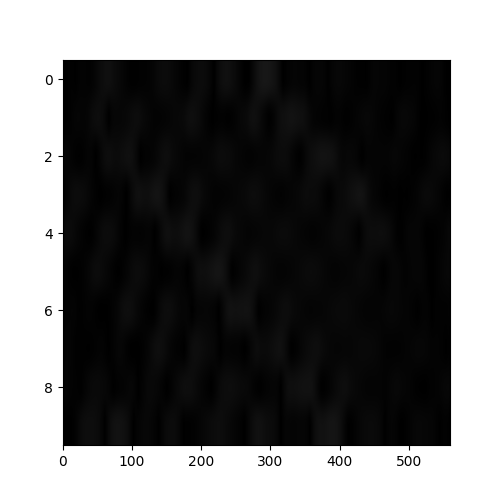

In [7]:
kymo = video_generator.get_kymo(10,noise_level = 0)[0]
filtered_kymo_left= filter_kymo_left(kymo)
filtered_kymo_right= filter_kymo_right(kymo)

np.mean(kymo),np.mean(filtered_kymo_left)
fig, ax = plt.subplots(figsize = (5,5))
ax.imshow(kymo, aspect='auto',cmap="gray",vmin=0,vmax= 255)
fig, ax = plt.subplots(figsize = (5,5))
ax.imshow(filtered_kymo_left, aspect='auto',cmap="gray",vmin=0,vmax= 255)
ax.set_title('this should only be lines moving to the right')
fig, ax = plt.subplots(figsize = (5,5))
ax.imshow(kymo-filtered_kymo_left, aspect='auto',cmap="gray",vmin=0,vmax= 255)
ax.set_title('this should only be lines moving to the left and static')

filtered_kymo_left_left= filter_kymo_left(kymo-filtered_kymo_left)
fig, ax = plt.subplots(figsize = (5,5))
ax.imshow(filtered_kymo_left_left, aspect='auto',cmap="gray",vmin=0,vmax= 255)

In [30]:


# Parameters for dataset generation
num_timesteps = 10  # Number of timesteps in each video
rect_size = (100, 700)
size_kymo = 200
def generate_sample():
    # Randomly choose parameters within a reasonable range
    left_speed = np.random.uniform(10, 60)
    right_speed = np.random.uniform(-60, -10)
    num_spots = np.random.randint(50, 1000)
    num_spots_imobile = np.random.randint(50, 500)
    noise_level = np.random.randint(9, 10)
    bias = np.random.uniform(0, 1)
    gaussian_range = (5,20)
    amplitude_range = (1, 2)
    # Create a video generator
    video_generator = MovingSpotsVideo(rect_size, left_speed, right_speed, num_spots,num_spots_imobile, bias, gaussian_range, amplitude_range)
    
    # Generate kymograph
    kymograph,filtered_kymo_left,filtered_kymo_right,left_kymo,right_kymo = video_generator.get_kymo(num_timesteps,noise_level = noise_level)
    # kymograph += np.random.random(size = kymograph.shape)/200*noise_level*0
    # Get flux value
    flux = video_generator.flux
    kymo = kymograph[:,:size_kymo]
    filtered_kymo_left = filter_kymo_left(kymo)
    filtered_kymo_right = filter_kymo_right(kymo)
    return kymo,filtered_kymo_left,filtered_kymo_right, flux,left_kymo[:,:size_kymo],right_kymo[:,:size_kymo]

In [31]:
from tqdm import tqdm
num_samples = 200  # Number of samples in the dataset

# Generate dataset
X = []
y = []
original_kymo_left = []
original_kymo_right = []

fourrier_kymo_left = []
fourrier_kymo_right = []


for _ in tqdm(range(num_samples), desc="Generating Samples"):
    kymo,filtered_kymo_left,filtered_kymo_right, flux,left_kymo,right_kymo= generate_sample()
    filtered_left_norm = (filtered_kymo_left - np.mean(kymo)) / np.std(kymo)
    filtered_right_norm = (filtered_kymo_right - np.mean(kymo)) / np.std(kymo)
    kymo_norm = (kymo - np.mean(kymo)) / np.std(kymo)
    # Stack the images along the new axis
    combined_image = np.stack([kymo_norm, filtered_left_norm, filtered_right_norm], axis=-1)

    # Add to the X array
    X.append(combined_image)
    y.append((left_kymo - np.mean(kymo)) / np.std(kymo))
    original_kymo_left.append(left_kymo)
    original_kymo_right.append(right_kymo)
    
    fourrier_kymo_left.append(filtered_kymo_left)
    fourrier_kymo_right.append(filtered_kymo_right)
    
    
    

X = np.array(X).reshape(-1, num_timesteps, size_kymo, 3)
y = np.array(y)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Generating Samples: 100%|█████████████████████████████████████████████████████████████| 200/200 [04:48<00:00,  1.44s/it]


Text(0, 0.5, 'fourrier extracted \n net flux')

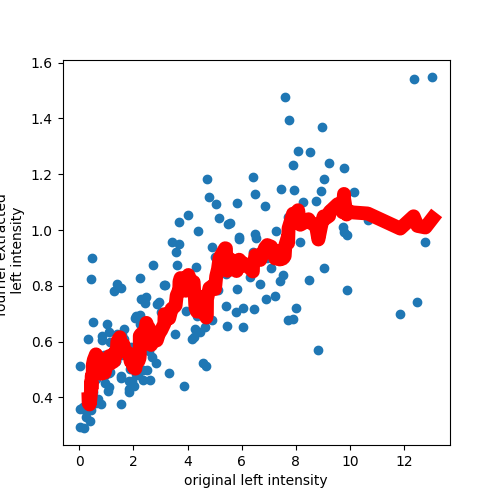

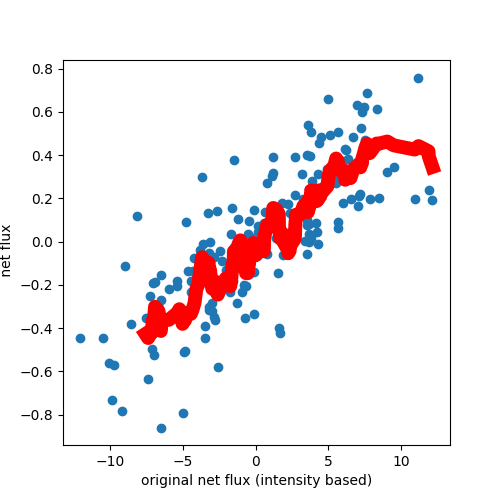

In [32]:
import pandas as pd

# Calculating the means
mean_original_left = np.mean(original_kymo_left, axis=(1, 2))
mean_fourrier_left = np.mean(fourrier_kymo_left, axis=(1, 2))
mean_original_right = np.mean(original_kymo_right, axis=(1, 2))
mean_fourrier_right = np.mean(fourrier_kymo_right, axis=(1, 2))

df = pd.DataFrame({
    'original_left': mean_original_left,
    'fourrier_left': mean_fourrier_left,
    'original_right': mean_original_right,
    'fourrier_right': mean_fourrier_right,
    
    
})
df = df.sort_values(by="original_left")
df['net_flux_original'] = df['original_left']-df['original_right']
df['net_flux_fourrier'] = df['fourrier_left']-df['fourrier_right']
df['total_flux_original'] = df['original_left']+df['original_right']
df['total_flux_fourrier'] = df['fourrier_left']+df['fourrier_right']

window_size = 10
rolling_avg_original = df['fourrier_left'].rolling(window=window_size,min_periods = 10).mean()
fig, ax = plt.subplots(figsize = (5,5))
ax.scatter(df['original_left'],df['fourrier_left'])
ax.plot(df['original_left'],rolling_avg_original,color="red",linewidth = 10)
df = df.sort_values(by="net_flux_original")
ax.set_xlabel('original left intensity')
ax.set_ylabel('fourrier extracted \n left intensity')



window_size = 10
rolling_avg_original = df['net_flux_fourrier'].rolling(window=window_size,min_periods = 10).mean()
fig, ax = plt.subplots(figsize = (5,5))
ax.scatter(df['net_flux_original'],df['net_flux_fourrier'])
ax.plot(df['net_flux_original'],rolling_avg_original,color="red",linewidth = 10)
df = df.sort_values(by="total_flux_original")
ax.set_xlabel('original net flux (intensity based)')
ax.set_ylabel('fourrier extracted \n net flux')